# 1 Problem Definition: Short Term Load Forecasting

Now the prblem includes Temperature as well, as an exogenous variable

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-09-13 14:03:59 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 1.67 s (started: 2024-09-13 14:03:59 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 1.77 s (started: 2024-09-13 14:04:01 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 109 ms (started: 2024-09-13 14:04:03 +02:00)


In [5]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 78 ms (started: 2024-09-13 14:04:03 +02:00)


# 3. Pre-processing


In [6]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 14:04:03 +02:00)


In [7]:
data = read_Data()

time: 31 ms (started: 2024-09-13 14:04:03 +02:00)


In [8]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 156 ms (started: 2024-09-13 14:04:03 +02:00)


# SVM II - Multi-step Forecasting with Exogenous variables

Multi-step forecasting involves predicting multiple future data points in the time series based on the previous data points. The model's objective is to predict a sequence of future values, given the historical data.

## Organizing the Feature Matrix

In [9]:
#Checking Data:
data.sample(3)

,load,T
2008-12-14 07:00:00,2795.0,15.67
2007-04-24 08:00:00,3341.0,58.00
2006-11-04 20:00:00,3621.0,35.00


time: 0 ns (started: 2024-09-13 14:04:03 +02:00)


In [10]:
# We are interested in the 'load' column, but we'll add some statistical features to help our model.
load_data = data[['load']]

# We define a window width of 24 hours to calculate rolling statistics.
width = 24
window = load_data.rolling(window=width)

# Create a new DataFrame with median and standard deviation of 'load' over the window, and also include the temperature ('T').
new_dataframe = pd.concat([window.median(), window.std(), data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std', 'T', 'load']

# Drop any rows with NaN values that were created as a result of rolling calculations.
new_dataframe.dropna(inplace=True) 
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 31 ms (started: 2024-09-13 14:04:03 +02:00)


In [11]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 0 ns (started: 2024-09-13 14:04:03 +02:00)


## Building the X Matrix and Labels

Here we will add the temporal data with sliding intervals in time. Lets first look with an illustration:

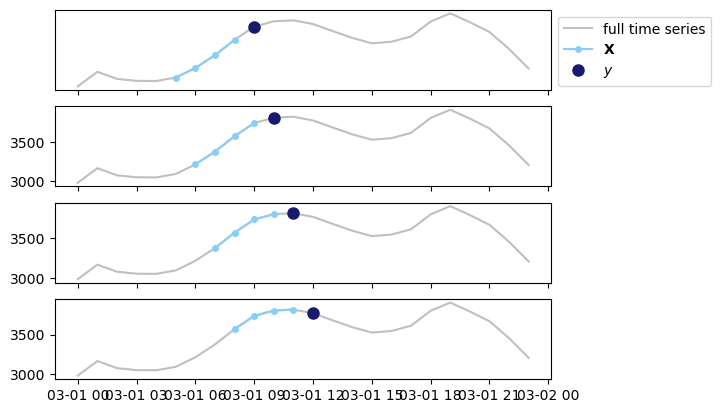

time: 593 ms (started: 2024-09-13 14:04:03 +02:00)


In [12]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2014-03-01 00:00:00')[0][0]
middle = np.where(new_dataframe.index == '2014-03-01 12:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-03-02 00:00:00')[0][0]
#sliding window width:
window = 4
#Plotting a sliding interval sample:
fig, ax = plt.subplots(nrows=4,sharex=True);
for i in range(4): 
    full = new_dataframe.iloc[start:end]['load']
    train = new_dataframe.iloc[middle - i - window:middle - i ]['load']
    predict = new_dataframe.iloc[middle - i:middle - i + 1]['load']

    ax[3-i].plot((full + 2*i),c='grey', alpha=0.5);
    ax[3-i].plot((train + 2*i),c=colors['lightskyblue'], markersize=4,marker='o')
    ax[3-i].plot((predict + 2*i),c=colors['midnightblue'], markersize=8,marker='o', linestyle='')

ax[0].get_yaxis().set_ticks([]);
ax[0].legend(['full time series','$\mathbf{X}$','$y$'],bbox_to_anchor=(1, 1));

Lets follow the same logic and create our feature matrix A in this way.

In [13]:
# Step 2: Preparing the Dataset for Modeling
# -------------------------------------------

# Define the start and end indices for our modeling period.
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]

# Now we set a wider window for extracting features to use in our SVM model.
window = 48  # This should match with your modeling requirement, we're using 48 for illustration.

time: 0 ns (started: 2024-09-13 14:04:04 +02:00)


In [14]:
# Step 3: Initialize lists for features, labels, and column names
dataX, dataY, column_names_list = [], [], []

for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names_list.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names_list)

dataX = pd.DataFrame(dataX, columns=column_names, index=new_dataframe.index[start + window:end])
dataY = pd.Series(dataY, name='true_load', index=new_dataframe.index[start + window:end])

time: 1.8 s (started: 2024-09-13 14:04:04 +02:00)


In [15]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 16 ms (started: 2024-09-13 14:04:06 +02:00)


In [16]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 16 ms (started: 2024-09-13 14:04:06 +02:00)


--> Please see that 2012-09-03 00:00:00 2630.0 in dataY is the same value for:
    2012-09-03 01:00:00 load_t_48 in dataX.
    
    Alignment: The last value in each dataX row (load_t_48) represents the 'load' at the end of the 48-hour window. The following value (which becomes the corresponding dataY value) is the 'load' you're trying to predict. That's why the dataY value for 2012-09-03 00:00:00 matches the last 'load' feature (load_t_48) for the dataX row starting at 2012-09-03 01:00:00. It signifies that dataY is correctly set as the target 'load' immediately following each feature window in dataX.

    Correctness: This setup indicates you've correctly shifted your target variable ('load') by one time step ahead of your features in dataX. This is a common approach in time series forecasting, where the goal is to predict future values based on past observations.

    When the window moves forward by one hour (from starting at 2012-09-01 00:00:00 to starting at 2012-09-01 01:00:00), the last value of this new window (load_t_48 for 2012-09-03 01:00:00) becomes the first 'load' value to predict (2012-09-03 00:00:00 in dataY).

In [17]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
Name: true_load, dtype: float64

time: 15 ms (started: 2024-09-13 14:04:06 +02:00)


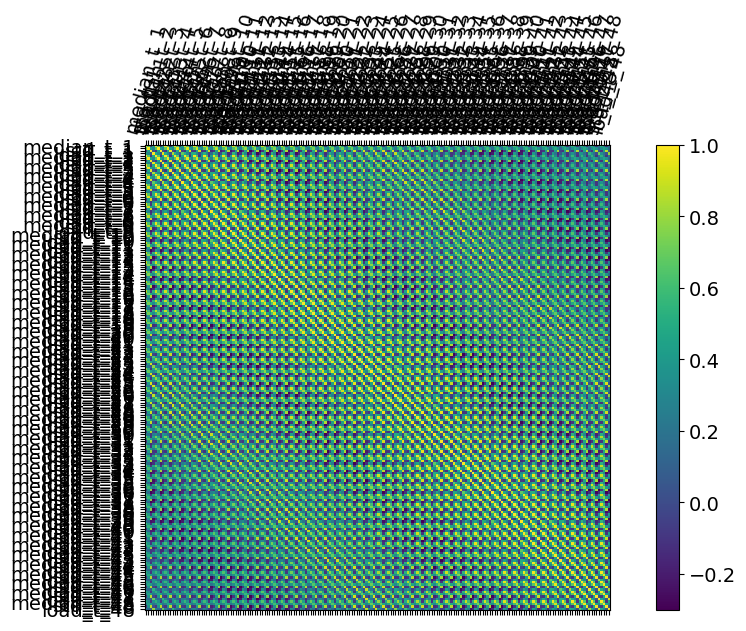

time: 3.34 s (started: 2024-09-13 14:04:06 +02:00)


In [18]:
# Correlation Matrix
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [19]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,-1.196200e-17,-1.674680e-16,1.226105e-16,1.943825e-16,1.256010e-16,-3.708220e-16,-3.289550e-17,-1.166295e-16,-1.913920e-16,...,1.555060e-16,-2.721355e-16,-5.741759e-16,-3.648410e-16,2.870880e-16,-1.854110e-16,6.339859e-16,2.631640e-16,-4.784800e-17,-1.764395e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 297 ms (started: 2024-09-13 14:04:09 +02:00)


In [20]:
# Train-Test Split:
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 16 ms (started: 2024-09-13 14:04:09 +02:00)


## Model Training and Predictions

As we have seen in the lecture, there are 3 important hyperparameters to decide: C, epsilon and kernel. We also need to feed the tol value as we are solving a convex optimization problem.

In [21]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2024-09-13 14:04:09 +02:00)


In [22]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 47 ms (started: 2024-09-13 14:04:09 +02:00)


In [23]:
#Model Predictions:
#------------------
#scoreTraining = model.score(X_train, y_train)
#print('-----------------------------------')
#print('SVM Regression Training R^2 Score: ', scoreTraining)
#print('-----------------------------------')
scoreValidation = model.score(X_test, y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Validation R^2 Score:  0.923579282187483
-----------------------------------
time: 16 ms (started: 2024-09-13 14:04:09 +02:00)


Training MSE: 8019.511874017913
Test MSE: 15620.405320125406


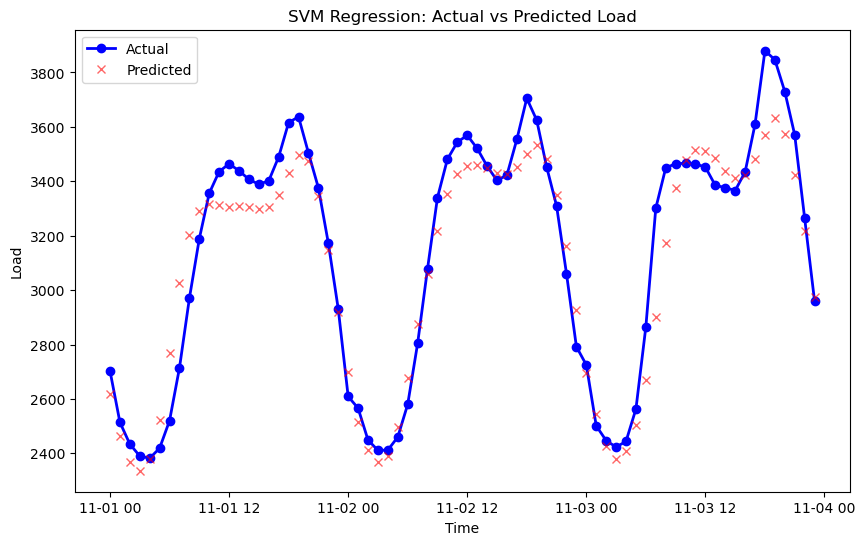

time: 187 ms (started: 2024-09-13 14:04:09 +02:00)


In [24]:
# Predict on training and test sets
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Evaluate the model
print(f"Training MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', alpha=0.6, marker='x', linestyle='None')
plt.title('SVM Regression: Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()